##### Import libraries

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 15.5 MB/s eta 0:00:00


In [3]:
import ultralytics

ultralytics.checks()

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


In [4]:
import os
import shutil
import xml.etree.ElementTree as ET

import yaml
from sklearn.model_selection import train_test_split

In [6]:
!gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
!unzip -q icdar2003.zip -d datasets

Downloading...
From (original): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
From (redirected): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV&confirm=t&uuid=486c8025-3323-4a94-9a56-59e0984fdb30
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 80.7MB/s]


##### Extract Data from XML and Store in YOLO format

In [7]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        # Store
        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib["x"]), int(image[1].attrib["y"])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [9]:
dataset_dir = "datasets/SceneTrialTrain"
words_xml_path = os.path.join(dataset_dir, "words.xml")
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(
    words_xml_path
)

In [10]:
print(f"Number of images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


##### Convert to YOLO format

In [11]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    yolo_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolo_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Calculate normalized bounding box coordinates
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Because we only have one class, we set class_id to 0
            class_id = 0

            # Convert to YOLO format
            yolo_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolo_labels.append(yolo_label)

        yolo_data.append((image_path, yolo_labels))

    return yolo_data

In [12]:
# Define class labels
class_labels = ["text"]

# Convert data into YOLO format
yolo_data = convert_to_yolo_format(image_paths, image_sizes, bounding_boxes)

##### Train, val, test split

In [13]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True
train_data, test_data = train_test_split(
    yolo_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)
test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

##### Save data

In [14]:
def save_data(data, src_img_dir, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "labels"), exist_ok=True)

    for image_path, yolo_labels in data:
        # Copy image to images folder
        shutil.copy(
            os.path.join(src_img_dir, image_path), os.path.join(save_dir, "images")
        )

        # Save labels to labels folder
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, "labels", f"{image_name}.txt"), "w") as f:
            for label in yolo_labels:
                f.write(f"{label}\n")

In [21]:
save_yolo_data_dir = "./datasets/yolo_data/"
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_test_dir = os.path.join(save_yolo_data_dir, "test")

save_data(train_data, dataset_dir, save_train_dir)
save_data(test_data, dataset_dir, save_val_dir)
save_data(val_data, dataset_dir, save_test_dir)

##### Create yaml file

In [22]:
data_yaml = {
    # "path": "../datasets/yolo_data/",
    "train": "train/images",
    "test": "test/images",
    "val": "val/images",
    "nc": 1,
    "names": class_labels,
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, "data.yml")
with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

In [23]:
yolo_yaml_path

'./datasets/yolo_data/data.yml'

##### Training

In [25]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11m.pt")

# Train model
results = model.train(
    data='/content/datasets/yolo_data/data.yml',
    epochs=100,
    imgsz=640,
    cache=True,
    patience=20,
    plots=True,
)

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/datasets/yolo_data/data.yml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 14.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 66.5MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/yolo_data/train/labels... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 937.18it/s]

train: New cache created: /content/datasets/yolo_data/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 200/200 [00:01<00:00, 114.41it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/yolo_data/val/labels... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 922.62it/s]

val: New cache created: /content/datasets/yolo_data/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 43/43 [00:00<00:00, 143.79it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       8.7G      2.074      2.985      1.832         52        640: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         43        200      0.586      0.605      0.633      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       8.7G      1.208      1.322       1.17         55        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.548       0.64      0.577      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.74G      1.143      1.178      1.127         26        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         43        200     0.0038      0.245    0.00258    0.00086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.67G       1.21      1.209      1.192         59        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200    0.00928       0.13    0.00304   0.000963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.74G      1.201      1.136       1.19         63        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         43        200    0.00675       0.03    0.00169   0.000427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.75G      1.319      1.136      1.213         69        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         43        200   0.000448      0.015   0.000218   7.58e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.73G      1.342      1.166       1.26         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         43        200     0.0382       0.07     0.0147    0.00424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.75G      1.341      1.169      1.252         53        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

                   all         43        200    0.00539      0.025    0.00205    0.00074



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.69G      1.311      1.106      1.219         39        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         43        200    0.00712       0.02     0.0011   0.000281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.75G       1.33      1.089      1.226         88        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         43        200     0.0303       0.09    0.00921    0.00399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.69G      1.266      1.032      1.197         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        200       0.03      0.035    0.00264    0.00105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.71G       1.26      1.037      1.216         46        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        200      0.349      0.645      0.328      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.69G      1.261      1.038      1.201         69        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.415      0.586       0.53      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.73G       1.18      1.018      1.156         34        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.481       0.63      0.537      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       8.7G      1.208      1.007      1.168         26        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.732      0.775      0.779      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.72G      1.123      0.971      1.145         36        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         43        200      0.664       0.72      0.709      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.68G      1.137     0.9375      1.168         94        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200        0.7      0.654      0.601      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.78G      1.147     0.9261      1.156         79        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         43        200      0.837      0.772      0.839      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.73G      1.098      0.861       1.13         83        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.674       0.73      0.705      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.78G      1.124     0.9181      1.158         46        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         43        200      0.765      0.775      0.782      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.63G      1.082     0.8766        1.1         54        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         43        200      0.857       0.79      0.832      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       8.7G      1.018     0.8231      1.074         38        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         43        200      0.757       0.82      0.775      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.71G      1.059     0.8363      1.105         30        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.733      0.795      0.716      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.76G      1.057     0.8487      1.096         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        200      0.727        0.8      0.727      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.71G     0.9863     0.7864       1.08         59        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.766      0.819      0.776       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.69G      1.007     0.7967      1.065         92        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.818      0.832      0.854      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.78G     0.9811      0.781      1.076         32        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         43        200      0.827      0.791      0.842      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.78G     0.9778     0.8214      1.073         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.877      0.905      0.917      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.67G      1.009     0.7905      1.085         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         43        200      0.878      0.845      0.904      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.73G      1.017     0.7671      1.056         75        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         43        200      0.802      0.875      0.849      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.71G     0.9858      0.725      1.069         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         43        200      0.802       0.88      0.829      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.75G     0.9516     0.7164      1.045         64        640: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.816      0.819      0.821      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.68G     0.9612     0.7296      1.053         72        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         43        200      0.817      0.855      0.847      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.72G      0.905      0.688      1.023         58        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         43        200      0.869       0.83      0.881       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.69G     0.9452     0.7297      1.049         68        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         43        200      0.855       0.86      0.893      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.75G     0.8932      0.715      1.028         67        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         43        200      0.884      0.837      0.871      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.71G       0.93     0.7218       1.05         39        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         43        200      0.863      0.835      0.875      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.69G     0.9852     0.7159      1.051         79        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         43        200      0.815       0.86      0.859       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.72G     0.8907     0.7032      1.037         68        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         43        200      0.838      0.835      0.877      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.69G     0.9022     0.6989      1.024         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         43        200       0.81       0.87      0.862      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.71G     0.8712     0.6815      1.015         55        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         43        200       0.84      0.845      0.863      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.69G     0.8782     0.6708      1.011         29        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         43        200      0.853      0.855      0.883       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.75G     0.8657      0.674      1.012         40        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.891       0.88      0.911      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.71G     0.7976     0.6018      1.004         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         43        200       0.89        0.9      0.902      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       8.7G     0.8488     0.6156      1.013         38        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         43        200      0.873      0.895      0.898      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.76G     0.8681     0.6465       1.01         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        200      0.779      0.896      0.841      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.75G     0.8412     0.6473       1.01         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         43        200      0.842      0.882      0.888      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.75G      0.873     0.6325      1.031         44        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.896      0.863      0.899      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.67G     0.8191     0.6034      0.988         80        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         43        200      0.851      0.858      0.883      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.73G     0.8208     0.6283      1.027         44        640: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.828      0.785      0.857       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.62G     0.8094     0.6074      1.014         24        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         43        200      0.778      0.859      0.868      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       8.6G     0.8267      0.601     0.9772         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.848      0.838       0.86      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.64G     0.8203     0.5826     0.9974         36        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.897      0.845      0.896      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.77G     0.8011      0.598     0.9829         67        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.915       0.86      0.916      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.75G     0.7939      0.589     0.9927         52        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        200      0.917       0.82       0.91      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.73G     0.7825     0.5788     0.9682         70        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         43        200      0.876       0.83      0.895      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.63G     0.7795     0.5603     0.9752        103        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         43        200      0.856      0.905      0.902      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       8.7G     0.8007     0.5729     0.9864         52        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         43        200      0.904       0.89      0.912      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.77G     0.8128     0.5748     0.9891         57        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         43        200      0.864      0.891      0.896      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.61G     0.8073      0.575     0.9995         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         43        200      0.902      0.872      0.911        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.67G     0.8222     0.6033       1.04         32        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         43        200      0.873       0.89      0.914      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.61G     0.7973     0.5548     0.9893         68        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         43        200      0.818      0.905      0.896      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       8.7G     0.7973     0.5468     0.9639         73        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.857       0.87      0.903       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.75G     0.7834       0.53     0.9791         36        640: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         43        200      0.778      0.895       0.87      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.64G     0.7625     0.5447     0.9694         39        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        200      0.857      0.885      0.906      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.69G     0.7491     0.5093     0.9738         44        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         43        200      0.909       0.88      0.915      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       8.7G     0.7536     0.5425      0.969         36        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        200      0.892      0.904      0.911      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.68G      0.778     0.5283      0.973         40        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         43        200      0.831      0.905      0.895      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.72G     0.7612     0.5294     0.9716         42        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


                   all         43        200       0.88       0.88      0.913      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.74G     0.7329     0.5273     0.9816         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.861      0.915      0.916      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       8.7G     0.7068     0.5079     0.9462         84        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


                   all         43        200      0.904      0.897      0.911      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.78G     0.6843     0.5139     0.9452         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.888      0.915        0.9      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.67G     0.6991     0.4905     0.9354         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         43        200      0.909      0.905      0.922      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       8.6G     0.6998     0.4793     0.9436         48        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        200      0.902      0.925      0.922      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.69G     0.6774     0.4862     0.9393         74        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

                   all         43        200      0.862      0.908      0.917      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.72G     0.7107     0.4945     0.9508         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         43        200      0.888       0.91      0.917      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.67G     0.6968     0.5019     0.9485        101        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         43        200        0.9       0.91      0.917        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.74G     0.6566     0.4533     0.9355         45        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.861       0.93      0.915       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.69G     0.6682     0.4608     0.9319         59        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         43        200       0.86      0.925      0.926      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       8.7G     0.6718     0.4785     0.9342         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         43        200      0.928      0.902      0.934      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.71G     0.6715     0.4549     0.9307         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.933      0.895      0.931      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.71G     0.7154       0.46     0.9598         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         43        200       0.91      0.905      0.919      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       8.6G     0.6504     0.4447      0.921         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.874        0.9      0.909      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.69G     0.6577     0.4617     0.9424         44        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         43        200      0.921      0.855       0.91       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       8.6G     0.6451     0.4398      0.923         85        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         43        200      0.931      0.878       0.92      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.74G     0.6423     0.4579     0.9395         38        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


                   all         43        200      0.927      0.895      0.925       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.71G     0.6764     0.4364     0.9205         53        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.927      0.905      0.924       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.67G      0.655     0.4382     0.9381         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         43        200      0.933      0.907       0.93      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.62G     0.6323     0.4223     0.9137         91        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.914      0.907      0.924      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       8.7G     0.6249     0.4153     0.9152         55        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


                   all         43        200      0.908      0.891       0.92      0.705
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.72G      0.702     0.4809     0.9369         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         43        200      0.862       0.93       0.92       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.69G     0.6702     0.4683     0.9189         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         43        200      0.877       0.89      0.924      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.61G     0.6615     0.4501      0.921         19        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         43        200      0.859       0.92       0.92      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       8.7G     0.6412      0.457     0.9025         55        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        200       0.87      0.915      0.921      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       8.7G     0.6744     0.4486     0.9095         29        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         43        200      0.878       0.93       0.92      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.75G     0.6488     0.4666      0.922         19        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.873      0.925      0.921      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.66G      0.643     0.4359     0.9124         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         43        200      0.918       0.89      0.919      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.78G     0.6458     0.4349     0.9225         28        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         43        200      0.928      0.898      0.919      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.72G     0.6402      0.442      0.913         18        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.923      0.901      0.917      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.77G     0.6068     0.4126     0.8904         36        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         43        200      0.913      0.905      0.917      0.717



100 epochs completed in 0.262 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 40.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


                   all         43        200      0.933      0.895      0.931      0.733
Speed: 0.3ms preprocess, 9.7ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train4


##### Evaluation

In [27]:
from ultralytics import YOLO

model_path = "/content/runs/detect/train4/weights/best.pt"
model = YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning /content/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


                   all         43        200      0.933      0.895      0.931      0.733
Speed: 0.3ms preprocess, 25.5ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/detect/val


##### Inference

In [28]:
import json

import cv2
import matplotlib.pyplot as plt


def visualize_bbox(
    img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction["confidence"]

        if conf_score < conf_thres:
            continue

        bbox = prediction["box"]
        xmin = int(bbox["x1"])
        ymin = int(bbox["y1"])
        xmax = int(bbox["x2"])
        ymax = int(bbox["y2"])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(
            img,
            (xmin, ymin - text_height - 5),
            (xmin + text_width, ymin),
            (0, 255, 0),
            -1,
        )
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)

    return img

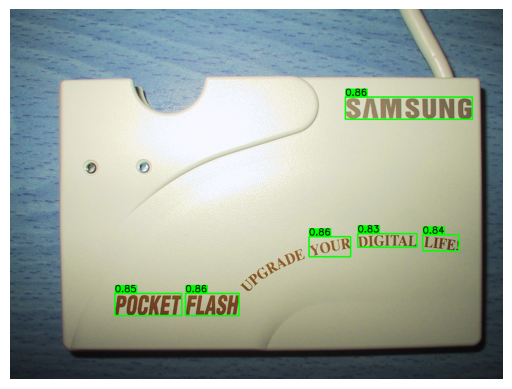

In [30]:
from ultralytics import YOLO

model_path = "/content/runs/detect/train4/weights/best.pt"
img_path = "datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG"
conf_thres = 0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis("off")
plt.show()